Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

# This is a notebook that uses real-world data and fits models to calibrate the COVID-19 simulation environment

### What does it mean to calibrate the simulation?

Simply put, we want to set the parameters of the simulation so that its behavior is consistent with real-world data.

To go into a bit more detail, the point of the simulation is to capture how public health policy decisions influence the spread of COVID-19 and influence the economy.
We model the spread of COVID-19 through a set of **SIR (+vaccination)** models, one for each US State.
We model the economy through a model of **unemployment** (again, one for each US State) and relief payments provided by the federal government.

Both the SIR disease dynamics and unemployment respond to public health policy decisions.
This notebook quantifies those responses as measured in the real world data, and exports that quantification as parameters that the simulation can use.

Another function of the simulator is to quantify **social welfare**, which is the metric that we want to maximize.
Our simulation defines social welfare as  
$$W = \alpha H + (1-\alpha)E$$
where $H$ and $E$ are indices representing the health outcome (i.e. COVID deaths) and economic outcome (i.e. GDP). 
$\alpha$ is a weighting term (between 0 and 1).

We don't know what the actual goals/priorities were of real-world policymakers, but we want to calibrate $\alpha$ (separately for each US State) so that the resulting definition of social welfare is most consistent with public health policy decisions made in the real world.

### Dependencies

In [1]:
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy
from scipy.signal import convolve
from scipy.optimize import minimize
from tqdm import tqdm

import ai_economist

Inside covid19_components.py: 1 GPUs are available.
Inside covid19_env.py: 1 GPUs are available.


In [2]:
### Install torch 1.8.0 or higher (required for the unemployment fits)
# !pip install torch==1.8.0

import torch
import torch.nn as nn

Before running this notebook, 
1. Please use the **gather_real_world_data.ipynb** notebook to download and pre-processing the raw real-world data.
2. Please set the base directory path below; it is the folder into which the real_world data have been downloaded, and it corresponds to the BASE_DATA_DIR_PATH in gather_real_world_data.ipynb notebook (and defaults to "/tmp/covid19_data")

In [3]:
BASE_DATA_DIR_PATH = "/home/ubuntu/ai-economist/ai_economist/datasets/covid19_datasets"  # SPECIFY A BASE DIRECTORY TO STORE ALL THE DOWNLOADED DATA

In [4]:
# BASE_DATA_DIR_PATH = "/home/ubuntu/ai-economist/ai_economist/datasets/covid19_datasets/2024-02-18"

DOWNLOAD_LATEST_DATA = True  # Download the latest data or use whatever is saved earlier 
CURRENT_DATE = datetime.now()
DATE_FORMAT = "%Y-%m-%d"
date_string = CURRENT_DATE.strftime(DATE_FORMAT).replace('/','-')
data_dir = os.path.join(BASE_DATA_DIR_PATH, date_string)
BASE_DATA_DIR_PATH = data_dir
print("All the data will be downloaded to the directory: '{}'.".format(data_dir))

All the data will be downloaded to the directory: '/home/ubuntu/ai-economist/ai_economist/datasets/covid19_datasets/2024-09-16'.


### Use the latest dated folder in BASE_DATA_DIR_PATH to fetch the real-world data
Note: if you do not wish to use the latest data, you will need to manually overwrite the data_dir variable

In [5]:
data_dir = BASE_DATA_DIR_PATH
print("In this notebook, we will use the real world data saved in '{}'".format(data_dir))

In this notebook, we will use the real world data saved in '/home/ubuntu/ai-economist/ai_economist/datasets/covid19_datasets/2024-09-16'


### Read in the model constants

In [6]:
with open(os.path.join(data_dir, "model_constants.json"), "r") as fp:
    model_constants = json.load(fp)
    
DATE_FORMAT = model_constants["DATE_FORMAT"]
STRINGENCY_POLICY_KEY = model_constants["STRINGENCY_POLICY_KEY"]

## This notebook uses the real-world data to calibrate the simulation.

### What does it mean to calibrate the simulation?

Simply put, we want to set the parameters of the simulation so that its behavior is consistent with real-world data.

To go into a bit more detail, the point of the simulation is to capture how public health policy decisions influence the spread of COVID-19 and influence the economy.
We model the spread of COVID-19 through a set of **SIR (+vaccination)** models, one for each US State.
We model the economy through a model of **unemployment** (again, one for each US State) and relief payments provided by the federal government.

Both the SIR disease dynamics and unemployment respond to public health policy decisions.
This notebook quantifies those responses as measured in the real world data, and exports that quantification as parameters that the simulation can use.

Another function of the simulator is to quantify **social welfare**, which is the metric that we want to maximize.
Our simulation defines social welfare as  
$$W = \alpha H + (1-\alpha)E$$
where $H$ and $E$ are indices representing the health outcome (i.e. COVID deaths) and economic outcome (i.e. GDP). 
$\alpha$ is a weighting term (between 0 and 1).

We don't know what the actual goals/priorities were of real-world policymakers, but we want to calibrate $\alpha$ (separately for each US State) so that the resulting definition of social welfare is most consistent with public health policy decisions made in the real world.

# Set data / fit parameters:

In [7]:
# Set up dictionary to write fitted parameters
fitted_params_dict = {'settings': {}}
fitted_params_filename = "fitted_params.json"

First, choose the dates we'll use to split the data.

- Data until the last date for **training** can be used to directly fit parameters.

- Date until the last date for **validation** can be used for measuring fit quality.

Our default calibration settings use data in 2020 for fitting (training+validation) so that data in 2021 can be held out as a test set.

In [8]:
# Do fitting up until the last day in the train set:
fitted_params_dict['settings']['LAST_DATE_IN_TRAIN_SET'] = '2020-11-30'
# Cross validation should uses non-training data up until:
fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET'] = '2022-12-31'

Next, set some parameters governing how the SIR and unemployment models use their data. The provided default settings yield good fits for the default date range (above).

In [9]:
# Length of the convolutional filters to use in the unemployment fitting
fitted_params_dict['settings']['FILTER_SIZE_UNEMPLOYMENT'] = 600
# Weight of regularization term to enforce state-by-state similarity in unemployment fits
fitted_params_dict['settings']['SIMILARITY_REGULARIZATION_UNEMPLOYMENT'] = 0.5

# Weight of regularization term to enforce state-by-state similarity in Beta fits (for SIR model)
fitted_params_dict['settings']['SIMILARITY_REGULARIZATION_SIR'] = 1.0

Lastly, set the environment configuration that we will use when we calibrate $\alpha$ values (which determine how social welfare is computed).

Note! $\alpha$ calibration is sensitive to these choices, so we will want to take care to use these same settings between calibration and any downstream experiments.

In [10]:
# Env settings for calibrating alphas. Default settings reflect env defaults.
fitted_params_dict['settings']['env'] = {
    'economic_reward_crra_eta': 2,
    "start_date": '2020-03-22',
    "infection_too_sick_to_work_rate": 0.1,
    "pop_between_age_18_65": 0.6,
    "risk_free_interest_rate": 0.03,
}

### Load real_world_data

In [11]:
dataframes = pickle.load( open(os.path.join(data_dir, "dataframes.pkl"), "rb" ) )

# 1. Beta Fits

Here, we calibrate the **SIR** model.

Within the SIR model, the **beta** parameter controls the rate that infections spread from infected people to susceptible people. It reflects the probability of disease transmission when a member from each group come in contact, and the rate at which those groups come into contact.

As such, the public health policy can affect beta (intuitively, through its influence on how often people interact with one another).

Our simulation models the relationship between public health policy (i.e. "stringency") and beta via a time-delayed linear model. 
Specifically, we model beta of US State $i$ at time $t$ as

$$\beta_{i,t} = \beta_{i}^{\pi} \cdot \pi_{i,t-d} + \beta_{i}^{0},$$

where $\pi_{i,t-d}$ is the stringency level $d$ days ago, $\beta_{i}^{\pi}$ is the slope, and $\beta_{i}^{0}$ is the intercept.

  
  
The next block of code finds the time delay $d$ and then fits the slope and intercept parameters for each US State. 
Each State uses the same delay.
In addition, we regularize the State-to-State differences in slope/intercept parameters to help reduce overfitting to noise.

**NOTE!** Although we're directly fitting linear models of beta, our ground-truth data is COVID-19 deaths. The best test of this fit is how well our simulation reproduces the COVID-19 death data given the real-world policy choices.

In [12]:
# This is the subset of the data we will use:
beta_df = dataframes["beta"]
policy_df = dataframes["policy"]

### Find the optimal delay in the response of beta (IT SHOULD BE >0)

Step through many possible policy delays to find where the empirical correlation between delayed policy and beta is strongest. Since all US States will use the same delay, we aggregate the data across states.

Intuitively, we expect higher stringency to lead to smaller beta, so we're actually looking for the delay where the correlation is smallest (i.e. most negative).

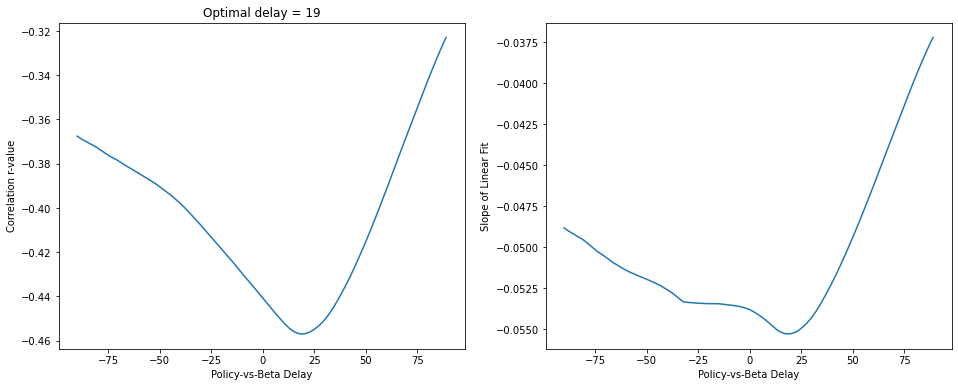

In [13]:
delays = list(range(-90, 90))

fits = []

for delay in delays:
    D = fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']
    if delay < 0:
        x = policy_df[:D].values[-delay:].flatten()
        y = beta_df[:D].values[:delay].flatten()
    elif delay == 0:
        x = policy_df[:D].values.flatten()
        y = beta_df[:D].values.flatten()
    else:
        x = policy_df[:D].values[:-delay].flatten()
        y = beta_df[:D].values[delay:].flatten()
    keep = np.logical_not(np.logical_or(np.isnan(y), np.isnan(x)))

    x = x[keep]
    y = y[keep]
    fit = scipy.stats.linregress(x, y)
    
    fits.append(fit)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6));
ax0.plot(delays, [f.rvalue for f in fits]);
ax0.set_xlabel('Policy-vs-Beta Delay');
ax0.set_ylabel('Correlation r-value');

ax1.plot(delays, [f.slope for f in fits]);
ax1.set_xlabel('Policy-vs-Beta Delay');
ax1.set_ylabel('Slope of Linear Fit');

BETA_DELAY = delays[np.argmin(np.array([f.rvalue for f in fits]))]
ax0.set_title('Optimal delay = {}'.format(BETA_DELAY));

### What does the aggregate policy vs. beta trend look like at this delay?

This plot shows the raw policy & beta data (blue) after applying the delay. The black dashed line shows the linear fit. The red points show the beta mean at each of the stringency levels.

Fit Intercept: +0.433488
Fit Slope:     -0.055298


/home/ubuntu/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


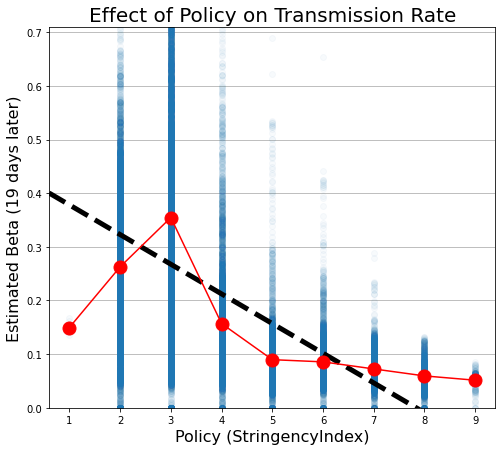

In [14]:
assert BETA_DELAY > 0

x = policy_df[:fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']].values[:-BETA_DELAY].flatten()
y = beta_df[:fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']].values[BETA_DELAY:].flatten()
keep = np.logical_not(np.logical_or(np.isnan(y), np.isnan(x)))

x = x[keep]
y = y[keep]
fit = scipy.stats.linregress(x, y)

print('Fit Intercept: {:+f}'.format(fit.intercept))
print('Fit Slope:     {:+f}'.format(fit.slope))

_, ax = plt.subplots(1, 1, figsize=(8, 7))

ax.plot(x, y, 'o', alpha=0.03);
xL = ax.get_xlim()
ax.plot(xL, [fit.intercept + fit.slope*x_ for x_ in xL], 'k--', linewidth=5);
ax.set_xlim(xL);

xs = np.sort(np.unique(x))
ys = np.zeros_like(xs, dtype=np.float)
for i, x_ in enumerate(xs):
    ys[i] = np.nanmean(y[x==x_])

ax.plot(xs, ys, 'ro-', markersize=13);

ax.set_ylim([0, 2*np.nanmax(ys)]);
ax.set_xlabel('Policy ({})'.format(STRINGENCY_POLICY_KEY), fontsize=16);
ax.set_ylabel('Estimated Beta ({} days later)'.format(BETA_DELAY), fontsize=16);
ax.set_title('Effect of Policy on Transmission Rate', fontsize=20);
ax.grid(b=True, axis='y');

This code sets up the regularized, State-by-State linear regression. It separates data for training/validation and defines the fitting procedure.

In [15]:
def shift_datestring(dstring, delta):
    return datetime.strftime(
        datetime.strptime(dstring, DATE_FORMAT) + timedelta(delta), DATE_FORMAT
    )

x_train_d0 = '2020-01-01'
x_train_dT = fitted_params_dict['settings']['LAST_DATE_IN_TRAIN_SET']
x_val_dT   = fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']
y_train_d0 = shift_datestring(x_train_d0, BETA_DELAY)
y_train_dT = shift_datestring(x_train_dT, BETA_DELAY)
y_val_dT   = shift_datestring(x_val_dT,   BETA_DELAY)

x_data = policy_df[x_train_d0:x_train_dT].values.T
y_data = beta_df[y_train_d0:y_train_dT].values.T

x_data_val = policy_df[x_train_dT:x_val_dT].values.T
y_data_val = beta_df[y_train_dT:y_val_dT].values.T

n_states = x_data.shape[0]

def predict_fn(x, weights):
    slopes = weights[:n_states, None]
    intercepts = weights[n_states:, None]
    return x*slopes + intercepts

def loss_fn(weights, w_sse_lambda):    
    y_hat = predict_fn(x_data, weights)
    y_sse = np.nansum((y_data - y_hat)**2)
    
    slopes = weights[:n_states]
    intercepts = weights[n_states:]
    s_sse = np.sum((slopes - np.mean(slopes))**2)
    i_sse = np.sum((intercepts - np.mean(intercepts))**2)
    
    return y_sse + w_sse_lambda*(s_sse*np.nanmean(x_data) + i_sse)
    
def do_fit(w_sse_lambda):
    w_bounds = [(None, 0)] * n_states
    i_bounds = [(0, None)] * n_states
    res = minimize(
        loss_fn,
        np.zeros(n_states * 2),
        args=(w_sse_lambda),
        bounds=w_bounds + i_bounds,
    )

    weights = res.x
    slopes = weights[:n_states]
    intercepts = weights[n_states:]
    y_hat = predict_fn(x_data, weights)
    
    return weights, slopes, intercepts, y_hat

In [16]:

eposiode_length = datetime.strptime(
        fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET'], DATE_FORMAT
    ) - datetime.strptime(
        fitted_params_dict['settings']['env']['start_date'], DATE_FORMAT
    )
print(eposiode_length)

1014 days, 0:00:00


This code gives us a look at the fit parameters/quality for different regularization levels (lambda).

Notice how stronger regularization leads to more State-by-State similarity across the fit parameters. This also leads to slightly worse training $r^2$ and slightly better validation $r^2$, as one would typically expect.

For the default data split, validation $r^2$ is poor, but, as described above, we are more interested in fitting the *SIR model* (not just fitting betas). So, calibration settings should focus on how well the simulation predicts real-world COVID-19 deaths given the real-world policy.

In [17]:
# _, ax = plt.subplots(1, 1, figsize=(16, 6))
# _, axes = plt.subplots(2, 2, figsize=(16, 8))
# ax0, ax1, ax2, ax3 = axes.flatten()

# ax.plot(y_data.flatten(), label='Real Data');

# # (regularization_amount, plot_color, plot_style)
# plot_specs = [
#     ( 0.0, 'r', ':'),
#     ( 5.0, 'g', '--'),
#     (10.0, 'c', '-.'),
# ]
# for LAMBDA, color, linestyle in plot_specs:
#     weights, slopes, intercepts, y_hat = do_fit(w_sse_lambda=LAMBDA)
#     y_hat_val = predict_fn(x_data_val, weights)
#     print('lambda = {:5.1f},   r^2 = {:5.3f},   r^2 (val) = {:5.3f}'.format(
#         LAMBDA,
#         1 - np.nanvar((y_hat - y_data)) / np.nanvar(y_data),
#         1 - np.nanvar((y_hat_val - y_data_val)) / np.nanvar(y_data_val)
#     ))
    
#     ax.plot(y_hat.flatten(), color=color, linestyle=linestyle, label='Predicted (lambda={})'.format(LAMBDA));
#     ax0.plot(slopes, color=color, linestyle=linestyle, label='lambda={}'.format(LAMBDA));
#     ax1.plot(intercepts, color=color, linestyle=linestyle, label='lambda={}'.format(LAMBDA));
#     ax2.plot(intercepts+slopes, color=color, linestyle=linestyle, label='lambda={}'.format(LAMBDA));
#     ax3.plot(y_data.flatten(), y_hat.flatten(), 'o', color=color, alpha=0.1, label='lambda={}'.format(LAMBDA));

# LIM = [0, 0.3]
# ax3.plot(LIM, LIM, 'k--');
# ax3.set_xlim(LIM);
# ax3.set_ylim(LIM);

# for ax_ in [ax, ax0, ax1, ax2, ax3]:
#     ax_.legend();
    
# ax.set_ylabel('Beta');
# ax0.set_ylabel('Slope');
# ax1.set_ylabel('Intercept');
# ax2.set_ylabel('Beta @ stringency=1');
# ax3.set_ylabel('Predicted Beta');

# ax0.set_xlabel('State Index');
# ax1.set_xlabel('State Index');
# ax2.set_xlabel('State Index');
# ax3.set_xlabel('Actual Beta');

### Perform the actual calibration fit

In [18]:
# (if you want to tweak the regularization setting, you can do so here)
# fitted_params_dict['settings']['SIMILARITY_REGULARIZATION_SIR'] = ...

_, slopes, intercepts, y_hat = do_fit(
    w_sse_lambda=fitted_params_dict['settings']['SIMILARITY_REGULARIZATION_SIR']
)

# Update the calibration fit dictionary
fitted_params_dict.update(
    {
        "BETA_DELAY": BETA_DELAY,
        "BETA_SLOPES": slopes.tolist(),
        "BETA_INTERCEPTS": intercepts.tolist()
    }
)

# 2. Unemployment Fits

Here, we calibrate the **unemployment** model.

The simulation models unemployment using a time-series model that predicts a State’s unemployment rate based on its history of stringency level increases and decreases.

Each change triggers a combination of exponentially-decaying unemployment responses. We learn a shared set of those responses by learning a set of 5 decay lambdas. Each State separately fits its own model that says strongly each of those underlying responses is triggered by a change in stringency.

In math, the unemployment model looks like this:

$$
\tilde{U}_{i,t}^k = \sum_{t'=t-L}^{t'=t} e^{\frac{t'-t}{\lambda_k}} \cdot \Delta \pi_{i, t'}, \\
U_{i,t} = \texttt{softplus}\left( \sum_k w_{i, k} \cdot \tilde{U}_{i,t}^k \right) + U^0_i.
$$

$\tilde{U}_{i,t}^k$ describes the unemployment driven by the $k$-th component of the response. $\lambda_k$ is the decay constant for that component. $L$ is the total length of the response filters. And $\Delta \pi_{i,t}$ is how much the stringency changed in State $i$ on time $t$.

$U_{i,t}$ is the actual unemployment according to the model. It adds baseline unemployment $U^0_i$ to excess unemployment coming from the policy choices. Excess unemployment is a State-specific weighted sum of each $\tilde{U}_{i,t}^k$, with weights $w_{i,k}$, passed through a $\texttt{softplus}$ function so that excess unemployment is $\geq 0$.

Similar to the way we fit beta (above), we regularize State-to-State variability in $w_{i,k}$.

In [19]:
# This is the subset of the data we will use for calibrating the unemployment model
unemployment_df = dataframes["unemployment"]
policy_df = dataframes["policy"]

### Model set-up

For a model like this, we take advantage of the tools available through PyTorch. In particular, we instantiate the unemployment model as a PyTorch module, and write a simple wrapper to handle the data feeding, parameter updates, etc.

In [20]:
class SharedConvUnemp(nn.Module):
    """
    The unemployment model.
    Given a history of stringency changes, predicts current unemployment.
    Embeds the full set of shared and State-specific model weights.
    """
    def __init__(
        self, 
        x_dim,
        n_filters,
        filter_size,
        n_states=51,
        signal_bias=True,
        initial_lambda_guess=None,
    ):
        super().__init__()
        self.x_dim = int(x_dim)
        self.n_filters = int(n_filters)
        self.filter_size = int(filter_size)
        self.n_states = int(n_states)
        
        # We can use grouped 1D convolution to do state-specific projection of x --> signal
        #  Expects input of size [1, x_dim*n_states, time+filter_size] (+filter_size implies pre-padding)
        #  Output has size [1, n_filters*n_states, time+filter_size]
        self.signal = nn.Conv1d(
            in_channels=self.n_states*self.x_dim,
            out_channels=self.n_states*self.n_filters,
            kernel_size=1,
            groups=self.n_states,
            bias=bool(signal_bias),
        )
        
        # Convolve the learned "signal" with a shared bank of exponential filters w/ learnable lambdas
        #  Expects input of size [n_states, n_filters, time+filter_size] (+filter_size implies pre-padding)
        #  Output has size [n_states, 1, time+filter_size] (here, +filter_size comes from internal padding)
        self.conv_lambdas = nn.Parameter(initial_lambda_guess,
            requires_grad=True
        )
        self.f_ts = torch.tile(
            torch.flip(torch.arange(self.filter_size), (0,))[None, None],
            (1, self.n_filters, 1)
        )
        
        # State-specific unemployment offsets
        self.unemp_bias = nn.Parameter(
            torch.tensor(np.ones(self.n_states, dtype=np.float32)*3.5),
            requires_grad=True
        )
    
    def get_similarity_regularization_loss(self):
        w = self.signal.weight.flatten().view(self.n_states, -1)
        dev = w - w.mean(0, keepdim=True)
        mse = torch.pow(dev, 2).mean()
        return mse
        
    def x2signal(self, x):
        # Assume input is [n_states, x_dim, time+filter_size], reshape to size expected by self.signal
        x = x.reshape(1, self.n_states*self.x_dim, -1)
        signal = self.signal(x)
        # Output should be returned to [n_states, n_filters, time+filter_size]
        signal = signal.reshape(self.n_states, self.n_filters, -1)
        return signal
        
    def signal2unemp(self, signal):
        # Assume input is [n_states, n_filters, time+filter_size]
        conv_filters = torch.exp(-self.f_ts / self.conv_lambdas[None, :, None])
        unemp = nn.functional.conv1d(signal, conv_filters, padding=self.filter_size-1)
            
        # Output should be returned as [n_states, time] (i.e. we remove padded outputs)
        unemp = unemp.reshape(self.n_states, -1)[:, self.filter_size:-(self.filter_size-1)]
        
        # Soft clipping + baseline unemployment
        return nn.functional.softplus(unemp, beta=1) + self.unemp_bias[:, None]
        
    def forward(self, x):
        signal = self.x2signal(x)
        unemp = self.signal2unemp(signal)
        return unemp

In [21]:
class SharedConvUnempFitter:
    """
    Wrapper to handle the data feeding and training of the actual unemployment model.
    """
    def __init__(self,
                 policy_df=None,
                 unemployment_df=None,
                 lr=0.01, similarity_regularization_coeff=0.0,
                 filter_size=600, lambdas=np.array([30, 60, 130, 260, 540])
                 ):
        assert unemployment_df is not None
        
        self.n_filters = len(lambdas)
        self.filter_size = int(filter_size)
        self.similarity_regularization_coeff = float(similarity_regularization_coeff)
        self.last_training_time_index = unemployment_df[
            :fitted_params_dict['settings']['LAST_DATE_IN_TRAIN_SET']
        ].shape[0]
        
        # Use this to crop out nans
        keep = np.logical_not(np.isnan(unemployment_df[
            :fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']
        ].values.T[0]))
        
        # Set up the data
        self.x_data, self.x_th = self.preprocess_policy(policy_df[
            :fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']
        ].values[keep].T)
        
        self.y_data = unemployment_df[:fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']].values[keep].T
        self.y_th = torch.from_numpy(self.y_data.astype(np.float32))
        
        # Crop out any nan region
        
        # Create the model
        self.x_dim = self.x_data.shape[1]
        self.model = SharedConvUnemp(
            self.x_dim, self.n_filters, self.filter_size, signal_bias=False,
            initial_lambda_guess=torch.tensor(lambdas.astype(np.float32))
        )
        
        # Loss
        self.loss = nn.MSELoss()
        self.train_loss_history = []
        self.val_loss_history = []
        
        # Create the optimizer
        self.optim = torch.optim.Adam(self.model.parameters(), lr=float(lr))
        
    def preprocess_policy(self, raw_policy_data):
        # Expects policy data size is [n_states, t]
        pad_pol = np.pad(raw_policy_data, [(0, 0), (self.filter_size, 0)], constant_values=1)
        
        dpad = np.zeros_like(pad_pol)
        dpad[:, 1:] = pad_pol[:, 1:] - pad_pol[:, :-1]

        x_data = dpad[None]
        
        x_data = x_data.transpose(1, 0, 2)
        x_th = torch.from_numpy(x_data.astype(np.float32))
        
        return x_data, x_th
        
    def predict(self, numpy=True):
        y_hat = self.model(self.x_th.detach())
        if numpy:
            y_hat = y_hat.data.numpy()
        return y_hat
        
    def get_train_loss(self):
        y_hat = self.predict(numpy=False)
        y_hat_train = y_hat[:, :self.last_training_time_index]
        y_train = self.y_th[:, :self.last_training_time_index]
        loss = self.loss(y_hat_train, y_train)
        return loss
    
    def get_val_loss(self):
        y_hat = self.predict(numpy=False)
        y_hat_val = y_hat[:, self.last_training_time_index:]
        y_val = self.y_th[:, self.last_training_time_index:]
        loss = self.loss(y_hat_val, y_val)
        return loss
    
    def get_losses(self):
        y_hat = self.predict(numpy=False)
        
        y_hat_train = y_hat[:, :self.last_training_time_index]
        y_train = self.y_th[:, :self.last_training_time_index]
        train_loss = self.loss(y_hat_train, y_train)
        
        y_hat_val = y_hat[:, self.last_training_time_index:]
        y_val = self.y_th[:, self.last_training_time_index:]
        val_loss = self.loss(y_hat_val, y_val)
        
        return train_loss, val_loss
        
    def update(self):
        self.optim.zero_grad()
        
        # Get the training and val losses
        train_loss, val_loss = self.get_losses()
        self.train_loss_history.append(float(train_loss))
        self.val_loss_history.append(float(val_loss))
        
        # Add any similarity regularization loss
        if self.similarity_regularization_coeff:
            similarity_loss = self.model.get_similarity_regularization_loss()
            train_loss = train_loss + self.similarity_regularization_coeff*similarity_loss
        
        # Update
        train_loss.backward()
        self.optim.step()

### Perform the actual calibration fit

Initialize and fit the unemployment model (this will likely take a few minutes)

100%|██████████| 350/350 [01:52<00:00,  3.11it/s]


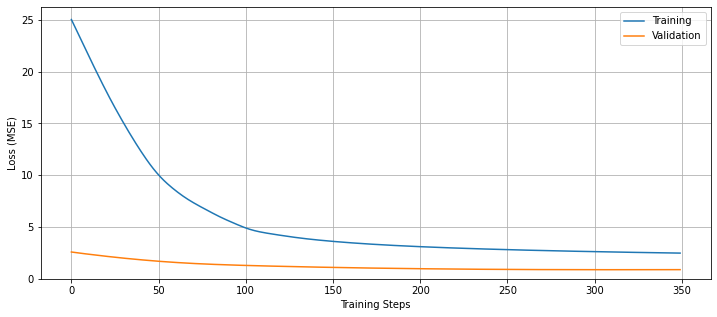

In [22]:
# (if you want to tweak the regularization setting, you can do so here)
# fitted_params_dict['settings']['FILTER_SIZE_UNEMPLOYMENT'] = ...
# fitted_params_dict['settings']['SIMILARITY_REGULARIZATION_UNEMPLOYMENT'] = ...

unemployment_fitter = SharedConvUnempFitter(
    policy_df=policy_df,
    unemployment_df=unemployment_df,
    filter_size=fitted_params_dict['settings']['FILTER_SIZE_UNEMPLOYMENT'],
    similarity_regularization_coeff=fitted_params_dict['settings']['SIMILARITY_REGULARIZATION_UNEMPLOYMENT'],
    lambdas=np.logspace(np.log10(30), np.log10(540), 5),
    lr=0.01,
)

# Recommend training for 350 steps with lr=0.01 and similarity regularization=0.5
for _ in tqdm(range(350)):
    unemployment_fitter.update()

_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(unemployment_fitter.train_loss_history, label='Training');
ax.plot(unemployment_fitter.val_loss_history, label='Validation');
ax.set_ylabel('Loss (MSE)');
ax.set_xlabel('Training Steps');
ax.legend();
ax.set_ylim(bottom=0);
ax.grid(b=True);

### How well does the predicted US unemployment match the real data?

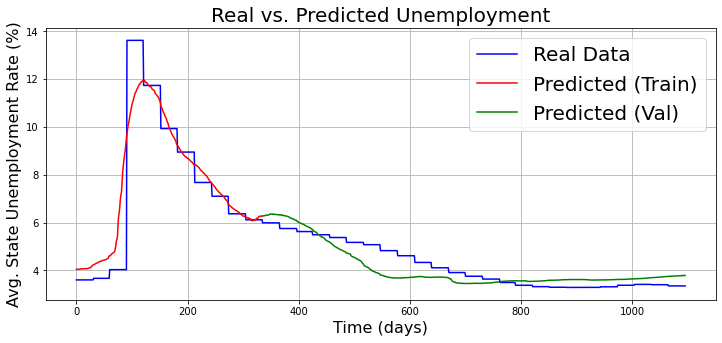

In [23]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

y_hat = unemployment_fitter.predict().mean(0)
t = np.arange(len(y_hat))

ax.plot(t, unemployment_fitter.y_data.mean(0), 'b', label='Real Data');
ax.plot(
    t[:unemployment_fitter.last_training_time_index],
    y_hat[:unemployment_fitter.last_training_time_index],
    'r-', label='Predicted (Train)'
);
ax.plot(
    t[unemployment_fitter.last_training_time_index:],
    y_hat[unemployment_fitter.last_training_time_index:],
    'g-', label='Predicted (Val)'
);
ax.grid(b=True);

ax.set_xlabel('Time (days)', fontsize=16);
ax.set_ylabel('Avg. State Unemployment Rate (%)', fontsize=16);
ax.set_title('Real vs. Predicted Unemployment', fontsize=20);
ax.legend(fontsize=20);

### How well does the predicted unemployment match the real data -- *for each state*?

**WARNING: Make sure the unemployment fits above look reasonable for all states before saving!** If not, re-run the fits above

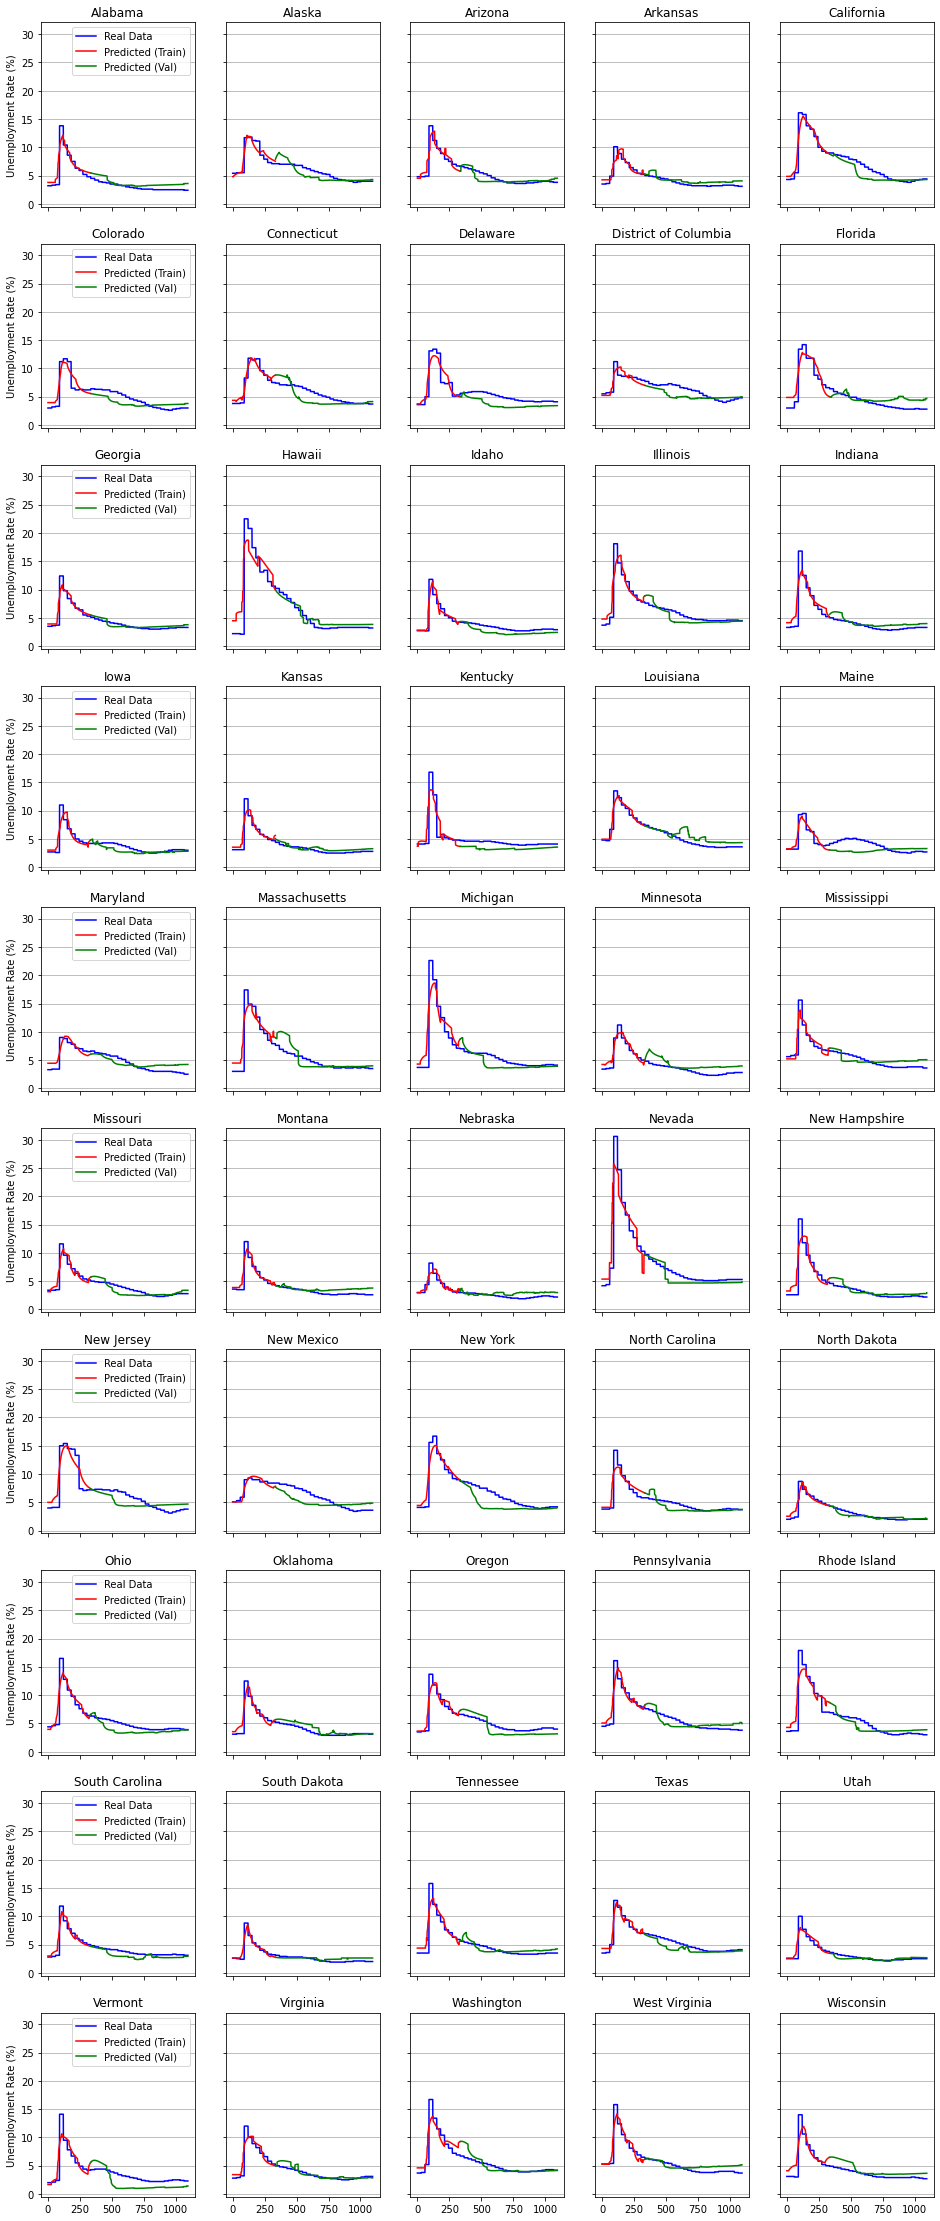

In [24]:
# Note, since there are 51 "states", this won't plot Wyoming.
_, axes = plt.subplots(10, 5, figsize=(16, 40), sharey=True, sharex=True)
axes = axes.flatten()

y_hat = unemployment_fitter.predict()
t = np.arange(y_hat.shape[1])
for IDX, ax in enumerate(axes):
    ax.plot(t, unemployment_fitter.y_data[IDX], 'b-', label='Real Data');
    ax.plot(
        t[:unemployment_fitter.last_training_time_index],
        y_hat[IDX, :unemployment_fitter.last_training_time_index], 
        'r-', label='Predicted (Train)'
    );
    ax.plot(
        t[unemployment_fitter.last_training_time_index:],
        y_hat[IDX, unemployment_fitter.last_training_time_index:],
        'g-', label='Predicted (Val)'
    );
    ax.grid(b=True, axis='y');
    ax.set_title(unemployment_df.columns[IDX]);
    if ax.is_first_col():
        ax.set_ylabel('Unemployment Rate (%)');
        ax.legend();

## When satisfied with the fits, export them as part of the calibration

In [25]:
# Update fitted_params_dict
# Note: we cast some arrays as np.float64 in order to be able to write out to a json file
fitted_params_dict.update(
    {
        "POLICY_START_DATE": datetime.strftime(policy_df.index[0], format=DATE_FORMAT),
        "FILTER_LEN": unemployment_fitter.filter_size,
        "CONV_LAMBDAS": [float(x) for x in unemployment_fitter.model.conv_lambdas.data.numpy()],
        "UNEMPLOYMENT_BIAS": [float(x) for x in unemployment_fitter.model.unemp_bias.data.numpy()],
        "GROUPED_CONVOLUTIONAL_FILTER_WEIGHTS": unemployment_fitter.model.signal.weight.data.numpy().tolist()
    }
)

# 3. Social Welfare

The simulator tracks **social welfare**, which is the metric that we want to maximize.
Our simulation defines social welfare as  
$W = \alpha H + (1-\alpha)E$  
where $H$ and $E$ are indices representing the health outcome ($H$ decreases with COVID deaths) and economic outcome ($E$ decreases with lost GDP). 
$\alpha$ is a weighting term (between 0 and 1).

We don't know what the actual goals/priorities were of real-world policymakers, but we want to calibrate $\alpha$ (separately for each US State) so that the resulting definition of social welfare is most consistent with public health policy decisions made in the real world.

*There is no definitive way to extract these priorities from the data. Our method is just one possible choice.*

The goal of this fitting procedure is to estimate what the outcomes would have been if only interested in either health (minimizing deaths) or in the economy (minimizing GDP loss), and then to compare these against the real-world policy outcomes in order to estimate the underlying policy priorities.

Another way to look at this is that we want to first measure the *shape* of the health/economy trade-off curve for each State. Then, we want to back out the health/economy prioritization (i.e. $\alpha_i$) that would make the outcomes under the real-world policy preferable to all other outcomes along that trade-off curve.

**We'll go into specifics as we proceed below...**

**Note:** this procedure also gives us the numbers we need to *normalize* $H$ and $E$ so that the Health and Economic Indices have a meaningful scale.

In [26]:
# The env requires the fitted params to run, and we require the env to calibrate the fitted params.
# Save some placeholders, which we'll update after calibration, then re-save.
path_to_data_and_fitted_params = "../../../datasets/covid19_datasets"
path_to_data_and_fitted_params = os.path.join(path_to_data_and_fitted_params, date_string)
fitted_params_dict.update(
    {
        "VALUE_OF_LIFE": 10000000,
        "INFERRED_WEIGHTAGE_ON_AGENT_HEALTH_INDEX": [0.5]*51,
        "INFERRED_WEIGHTAGE_ON_PLANNER_HEALTH_INDEX": 0.5,
        "MAX_MARGINAL_AGENT_ECONOMIC_INDEX": [1]*51,
        "MAX_MARGINAL_PLANNER_ECONOMIC_INDEX": 1,
        "MAX_MARGINAL_AGENT_HEALTH_INDEX": [1]*51,
        "MAX_MARGINAL_PLANNER_HEALTH_INDEX": 1,
        "MIN_MARGINAL_AGENT_ECONOMIC_INDEX": [0]*51,
        "MIN_MARGINAL_PLANNER_ECONOMIC_INDEX": 0,
        "MIN_MARGINAL_AGENT_HEALTH_INDEX": [0]*51,
        "MIN_MARGINAL_PLANNER_HEALTH_INDEX": 0,
    }
)
with open(os.path.join(data_dir, fitted_params_filename), "w") as fp: 
    json.dump(fitted_params_dict, fp)

# Define the configuration of the environment that will be built
N_ALPHA_CALIBRATION_DAYS = (
    datetime.strptime(
        fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET'], DATE_FORMAT
    ) - datetime.strptime(
        fitted_params_dict['settings']['env']['start_date'], DATE_FORMAT
    )
).days
env_config_dict = {
    # Scenario name - determines which scenario class to use
    "scenario_name": "CovidAndEconomySimulation",

    # The list of components in this simulation
    "components": [
        {"ControlUSStateOpenCloseStatus": {
            # action cooldown period in days.
            # Once a stringency level is set, the state(s) cannot switch to another level
            # for a certain number of days (referred to as the "action_cooldown_period")
            "action_cooldown_period": 28
        }},
        {"FederalGovernmentSubsidyAndQuantitativePolicies": {
            # The number of subsidy levels.
            "num_subsidy_quantitative_policy_level": 15,
            # The number of days over which the total subsidy amount is evenly rolled out.
            "subsidy_quantitative_policy_interval": 15,
            # The maximum annual subsidy that may be allocated per person.
            "max_annual_monetary_unit_per_person": 20000,
        }},
        {"VaccinationCampaign": {
            # The number of vaccines available per million people everyday.
            "daily_vaccines_per_million_people": 3000,
            # The number of days between vaccine deliveries.
            "delivery_interval": 1,
            # The date (YYYY-MM-DD) when vaccination begins
            "vaccine_delivery_start_date": "2021-01-12",
        }},
    ],

    # Date (YYYY-MM-DD) to start the simulation.
    "start_date": "2020-03-22",
    # How long to run the simulation for (in days)
    "episode_length": 500,

    # use_real_world_data (bool): Replay what happened in the real world.
    # Real-world data comprises SIR (susceptible/infected/recovered),
    # unemployment, government policy, and vaccination numbers.
    # This setting also sets use_real_world_policies=True.
    "use_real_world_data": False,
    # use_real_world_policies (bool): Run the environment with real-world policies
    # (stringency levels and subsidies). With this setting and
    # use_real_world_data=False, SIR and economy dynamics are still
    # driven by fitted models.
    "use_real_world_policies": False,
    "csv_validation": False,

    # Let the real-world state government handle the covid-19 restriction, and the federal government still operated by AI
    "state_governments_policies_only": False,
    "path_to_data_and_fitted_params": path_to_data_and_fitted_params,

    # A factor indicating how much more the
    # states prioritize health (roughly speaking, loss of lives due to
    # opening up more) over the economy (roughly speaking, a loss in GDP
    # due to shutting down resulting in more unemployment) compared to the
    # real-world.
    # For example, a value of 1 corresponds to the health weight that
    # maximizes social welfare under the real-world policy, while
    # a value of 2 means that states care twice as much about public health
    # (preventing deaths), while a value of 0.5 means that states care twice
    # as much about the economy (preventing GDP drops).
    "health_priority_scaling_agents": 1,
    # Same as above for the planner
    "health_priority_scaling_planner": 1,

    # Full path to the directory containing
    # the data, fitted parameters and model constants. This defaults to
    # "ai_economist/datasets/covid19_datasets/data_and_fitted_params".
    # For details on obtaining these parameters, please see the notebook
    # "ai-economist-foundation/ai_economist/datasets/covid19_datasets/
    # gather_real_world_data_and_fit_parameters.ipynb".
    

    # Economy-related parameters
    # Fraction of people infected with COVID-19. Infected people don't work.
    "infection_too_sick_to_work_rate": 0.1,
    # Fraction of the population between ages 18-65.
    # This is the subset of the population whose employment/unemployment affects
    # economic productivity.
    "pop_between_age_18_65": 0.6,
    # Percentage of interest paid by the federal
    # government to borrow money from the federal reserve for COVID-19 relief
    # (direct payments). Higher interest rates mean that direct payments
    # have a larger cost on the federal government's economic index.
    "risk_free_interest_rate": 0.03,
    # CRRA eta parameter for modeling the economic reward non-linearity.
    "economic_reward_crra_eta": 2,

    # Number of agents in the simulation (50 US states + Washington DC)
    "n_agents": 51,
    # World size: Not relevant to this simulation, but needs to be set for Foundation
    "world_size": [1, 1],
    # Flag to collate all the agents' observations, rewards and done flags into a single matrix
    "collate_agent_step_and_reset_data": False,
}

# env_config = {
#     "collate_agent_step_and_reset_data": True,
#     "scenario_name": "CovidAndEconomySimulation",
#     "path_to_data_and_fitted_params": data_dir,
    
#     "components": [
#         {"ControlUSStateOpenCloseStatus": {
#             "action_cooldown_period": 28
#         }},
#         {"FederalGovernmentSubsidyAndQuantitativePolicies": {
#             "num_subsidy_quantitative_policy_level": 143,
#             "subsidy_quantitative_policy_interval": 90,
#             "max_annual_monetary_unit_per_person": 20000,
#         }},
#         {"VaccinationCampaign": {
#             "daily_vaccines_per_million_people": 3000,
#             "delivery_interval": 1,
#             "vaccine_delivery_start_date": "2021-01-12",
#         }},
#     ],
#     "flatten_masks": False,
#     "flatten_observations": False,
#     "health_priority_scaling_agents": 1.0,
#     "health_priority_scaling_planner": 1.0,
#     "multi_action_mode_agents": False,
#     "multi_action_mode_planner": False,
#     "world_size": [1, 1],
#     "n_agents": 51,
#     "episode_length": N_ALPHA_CALIBRATION_DAYS,
# }
   
# NOTE!!!!
# The calibration will be specific to these choices!
# Downstream environments that use this calibration should also use these parameters!
env_config_dict.update(fitted_params_dict['settings']['env'])

# Build the environment from this partially-finished calibration.
uncalibrated_env = ai_economist.foundation.make_env_instance(**env_config_dict)

Using the real-world data to only initialize the env, and using the fitted models to step through the env.
../../../datasets/covid19_datasets/2024-09-16
Loading real-world data from /home/ubuntu/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/2024-09-16
/home/ubuntu/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/2024-09-16
Key:  policy  - size:  1096
Key:  subsidy  - size:  1096
Key:  quantitative  - size:  1096
Key:  inflation  - size:  1096
Key:  fed_fund_rate  - size:  1100
Key:  us_treasury_yield_long_10_years  - size:  1096
Key:  revenue  - size:  1096
Key:  spending  - size:  1096
Key:  debt  - size:  1096
Key:  deaths  - size:  1096
Key:  vaccinated  - size:  1096
Key:  smoothed_deaths  - size:  1096
Key:  susceptible  - size:  1096
Key:  infected  - size:  1096
Key:  recovered  - size:  1096
Key:  beta  - size:  1096
Key:  unemployment  - size:  1096
Key:  unemployed  - size:  1096
Loading fit 

To estimate $\hat{\alpha}_i$ (the hat symbol denotes that this is an estimate), we first collect simulated health/economic outcomes under 3 policies: the actual stringency choices, minimum stringency, and maximum stringency.


We use these outcomes to estimate the Pareto frontier in the $\left( H_i, E_i \right)$ coordinate space.


By definition, the $\left( H_i, E_i \right)$ coordinates for the minimum- and maximum-stringency policies define the endpoints of this frontier, at $\left(0, 1\right)$ and $\left(1, 0\right)$, respectively.  
(This definition comes from how we normalize the health/economic indices -- that is, they are scaled to reflect the range of outcomes spanning the minimum- and maximum-stringency policies.)

In [27]:
# Collect the outcomes under the actual policies and 2 extremes: fully-closed and fully-open

index_results = {}

for p in ['closed', 'open', 'actual']:

    uncalibrated_env.reset();
    for _ in range(uncalibrated_env.episode_length):
        if p == 'actual':
            t_str = uncalibrated_env.current_date.strftime(DATE_FORMAT)
            actions = {
                str(idx): policy_df[state][t_str]
                for idx, state in uncalibrated_env.us_state_idx_to_state_name.items()
            }
        
        elif p == 'closed':
            actions = {str(idx): 10 for idx in range(51)}
        
        elif p == 'open':
            actions = {str(idx): 1 for idx in range(51)}
        
        else:
            raise NotImplementedError

        uncalibrated_env.step(actions);

    health_and_economic_indices = {}
    for agent in uncalibrated_env.all_agents:
        health_and_economic_indices[agent.idx] = (
            float(agent.state["Health Index"] / uncalibrated_env.episode_length), 
            float(agent.state["Economic Index"] / uncalibrated_env.episode_length),
        )
    
    index_results[p] = health_and_economic_indices

Day  1
Postsubsidy Productivity  0.0
Day  2
Postsubsidy Productivity  45057323000.0
Day  3
Postsubsidy Productivity  94707510000.0
Day  4
Postsubsidy Productivity  144042840000.0
Day  5
Postsubsidy Productivity  193074940000.0
Day  6
Postsubsidy Productivity  241815290000.0
Day  7
Postsubsidy Productivity  290275230000.0
Day  8
Postsubsidy Productivity  338465800000.0
Day  9
Postsubsidy Productivity  386397700000.0
Day  10
Postsubsidy Productivity  434081730000.0
Day  11
Postsubsidy Productivity  481528350000.0
Day  12
Postsubsidy Productivity  528747430000.0
Day  13
Postsubsidy Productivity  575748600000.0
Day  14
Postsubsidy Productivity  622541300000.0
Day  15
Postsubsidy Productivity  669134400000.0
Day  16
Postsubsidy Productivity  715536900000.0
Day  17
Postsubsidy Productivity  761757100000.0
Day  18
Postsubsidy Productivity  807803000000.0
Day  19
Postsubsidy Productivity  853682700000.0
Day  20
Postsubsidy Productivity  899403940000.0
Day  21
Postsubsidy Productivity  94497525

Day  68
Postsubsidy Productivity  3006361800000.0
Day  69
Postsubsidy Productivity  3049727700000.0
Day  70
Postsubsidy Productivity  3093104700000.0
Day  71
Postsubsidy Productivity  3136493500000.0
Day  72
Postsubsidy Productivity  3179895000000.0
Day  73
Postsubsidy Productivity  3223310600000.0
Day  74
Postsubsidy Productivity  3266740500000.0
Day  75
Postsubsidy Productivity  3310186700000.0
Day  76
Postsubsidy Productivity  3353649000000.0
Day  77
Postsubsidy Productivity  3397129300000.0
Day  78
Postsubsidy Productivity  3440627700000.0
Day  79
Postsubsidy Productivity  3484145200000.0
Day  80
Postsubsidy Productivity  3527682800000.0
Day  81
Postsubsidy Productivity  3571240700000.0
Day  82
Postsubsidy Productivity  3614820300000.0
Day  83
Postsubsidy Productivity  3658421400000.0
Day  84
Postsubsidy Productivity  3702045300000.0
Day  85
Postsubsidy Productivity  3745692300000.0
Day  86
Postsubsidy Productivity  3789363300000.0
Day  87
Postsubsidy Productivity  3833058600000.0


We assume the Pareto frontier for State $i$ has form $E_i = (1-H_i)^{x_i}$ and that the coordinates associated with the actual-stringency policy are found along this frontier.

We set the shape parameter $x_i$ based on this latter assumption, and take $\hat{\alpha}_i$ as the value that maximizes social welfare along the estimated Pareto frontier:
$$
\hat{\alpha_i} = \max_{\alpha_i} \alpha_i H_i^{\pi} + \left(1-\alpha_i\right) E_i^{\pi} =
\max_{\alpha_i} \alpha_i H_i^{\pi} + \left(1-\alpha_i \right)\left(1- \left(1-H_i^{\pi}\right)^{x_i} \right),
$$

where the Economic Index $E_i^{\pi}$ and Health Index $H_i^{\pi}$ values are obtained from running the policies $\pi$ in the simulation.


In other words, given the estimate of the Pareto frontier, we find the $\hat{\alpha}_i$ that best rationalizes the outcomes obtained under the actual policy, i.e. the $\hat{\alpha}_i$ under which these outcomes ($E_i^{\pi}$  and $H_i^{\pi}$) are considered optimal.

In [28]:
# This function implements the process described above and adds some plotting so we can visualize things

def estimate_alpha_and_plot_rew_examples(state_idx, do_plot=True, ax=None):
        
    act_h, act_e = index_results["actual"][state_idx]  # actual health index, actual economic index
    max_h, min_e = index_results["closed"][state_idx]  # max health index, min economic index
    min_h, max_e = index_results["open"][state_idx]    # min health index, max economic index

    norm_idx_pairs = []
    for index_dict in index_results.values():
        h_index, e_index = index_dict[state_idx]
        nh = (h_index-min_h)/(max_h - min_h + 1e-10 )
        ne = (e_index-min_e)/(max_e - min_e + 1e-10 )
        norm_idx_pairs.append([nh, ne])
            
    # Split out the normalized health / economic indices
    norm_idx_pairs = np.array(norm_idx_pairs)
    nhs = norm_idx_pairs[:, 0]
    nes = norm_idx_pairs[:, 1]

    # We assume the coordinates along the pareto curve have this form:
    #    (h, e) = (h, (1-h)**pwr)
    # Fit the power terms of the estimated pareto curve
    def loss_fn(pwr):
        nes_hat = (1-(nhs**pwr))**(1/pwr)
        return np.sum((nes_hat - nes)**2)
    res = minimize(
        fun=loss_fn,
        x0=2,
        bounds=[(1.001, None)],
    )
    pwr = res.x
    
    # Given the supplied or fit powers, produce the estimated pareto curve (the set of hs/es coordinates)
    policies = np.linspace(0, 1, 1001)
    hs = policies**(1/pwr)
    es = (1-policies)**(1/pwr)
    
    # Find the alpha such that the optimal nh/ne coordinate is closest to the ACTUAL policy nh/ne coordinate
    nh = (act_h-min_h)/(max_h-min_h + 1e-10 )
    ne = (act_e-min_e)/(max_e-min_e + 1e-10 )
    alphas = np.linspace(0, 1, 1001)
    d_opt2actual = []
    # For each possible alpha ...
    for alpha in alphas:
        # ... find the optimal nh/ne coordinate for this alpha ...
        opt_nh_ne_index = np.argmax(alpha*hs + (1-alpha)*es)
        opt_nh = hs[opt_nh_ne_index]
        opt_ne = es[opt_nh_ne_index]
        # ... and store its distance to the ACTUAL h/e coordinate.
        d = np.sqrt(((nh-opt_nh)**2) + (ne-opt_ne)**2)
        d_opt2actual.append(d)
    # The inferred alpha is that where the distance measured above is lowest
    alpha = float(alphas[np.argmin(d_opt2actual)])
        
    if not do_plot:
        return alpha
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Plot a reward heatmap for the given alpha
    h_full, e_full = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
    r_full = alpha*h_full + (1-alpha)*e_full
    ax.imshow(r_full, aspect='auto', origin='lower')
    if ax.is_last_row():
        ax.set_xlabel('Normalized Health Index');
    if ax.is_first_col():
        ax.set_ylabel('Normalized Economic Index');
    
    # Add the observed h/e coordinates from actual policies
    for nh, ne in norm_idx_pairs:
        ax.plot(nh*100, ne*100, 'bo', markersize=12);
            
    # Add the estimated pareto boundary
    ax.plot(hs*100, es*100, 'w');
    
    # Mark the optimal point along the boundary for the given alpha
    rs = alpha*hs + (1-alpha)*es
    ax.plot(hs[rs.argmax()]*100, es[rs.argmax()]*100, 'o', markerfacecolor="None", 
            markersize=8, markeredgecolor='red', markeredgewidth=2);
    
    ax.set_title('{}; alpha={:4.2f}'.format(
        'USA' if state_idx=='p' else uncalibrated_env.us_state_idx_to_state_name[str(state_idx)],
        alpha,
    ))
    
    ax.set_xticklabels(
        ["{:3.2f}".format(x/100).rstrip('0').rstrip('.') for x in ax.get_xticks()]
    )
    ax.set_yticklabels(
        ["{:3.2f}".format(y/100).rstrip('0').rstrip('.') for y in ax.get_yticks()]
    )
    
    return alpha

## Here are some visualizations to make things more intuitive...

Blue dots are normalized outcomes from the actual policy, and the fully-closed and fully-open policies.

The white line connecting these dots estimates the pareto frontier.

The red circle is the best outcome on the pareto frontier for the estimated alpha.

The estimated alpha is the one that places the red circle closest to the actual-policy blue dot.

The heatmap background shows the reward at each coordinate (given $\hat{\alpha}_i$).

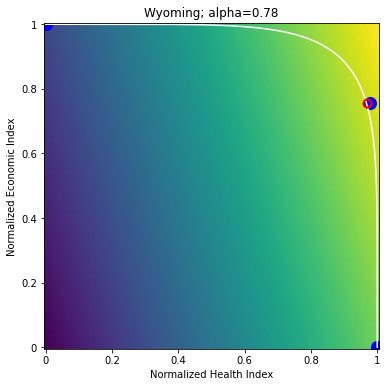

In [29]:
# Single-State plot so things are easier to see.
alpha = estimate_alpha_and_plot_rew_examples(state_idx=50);

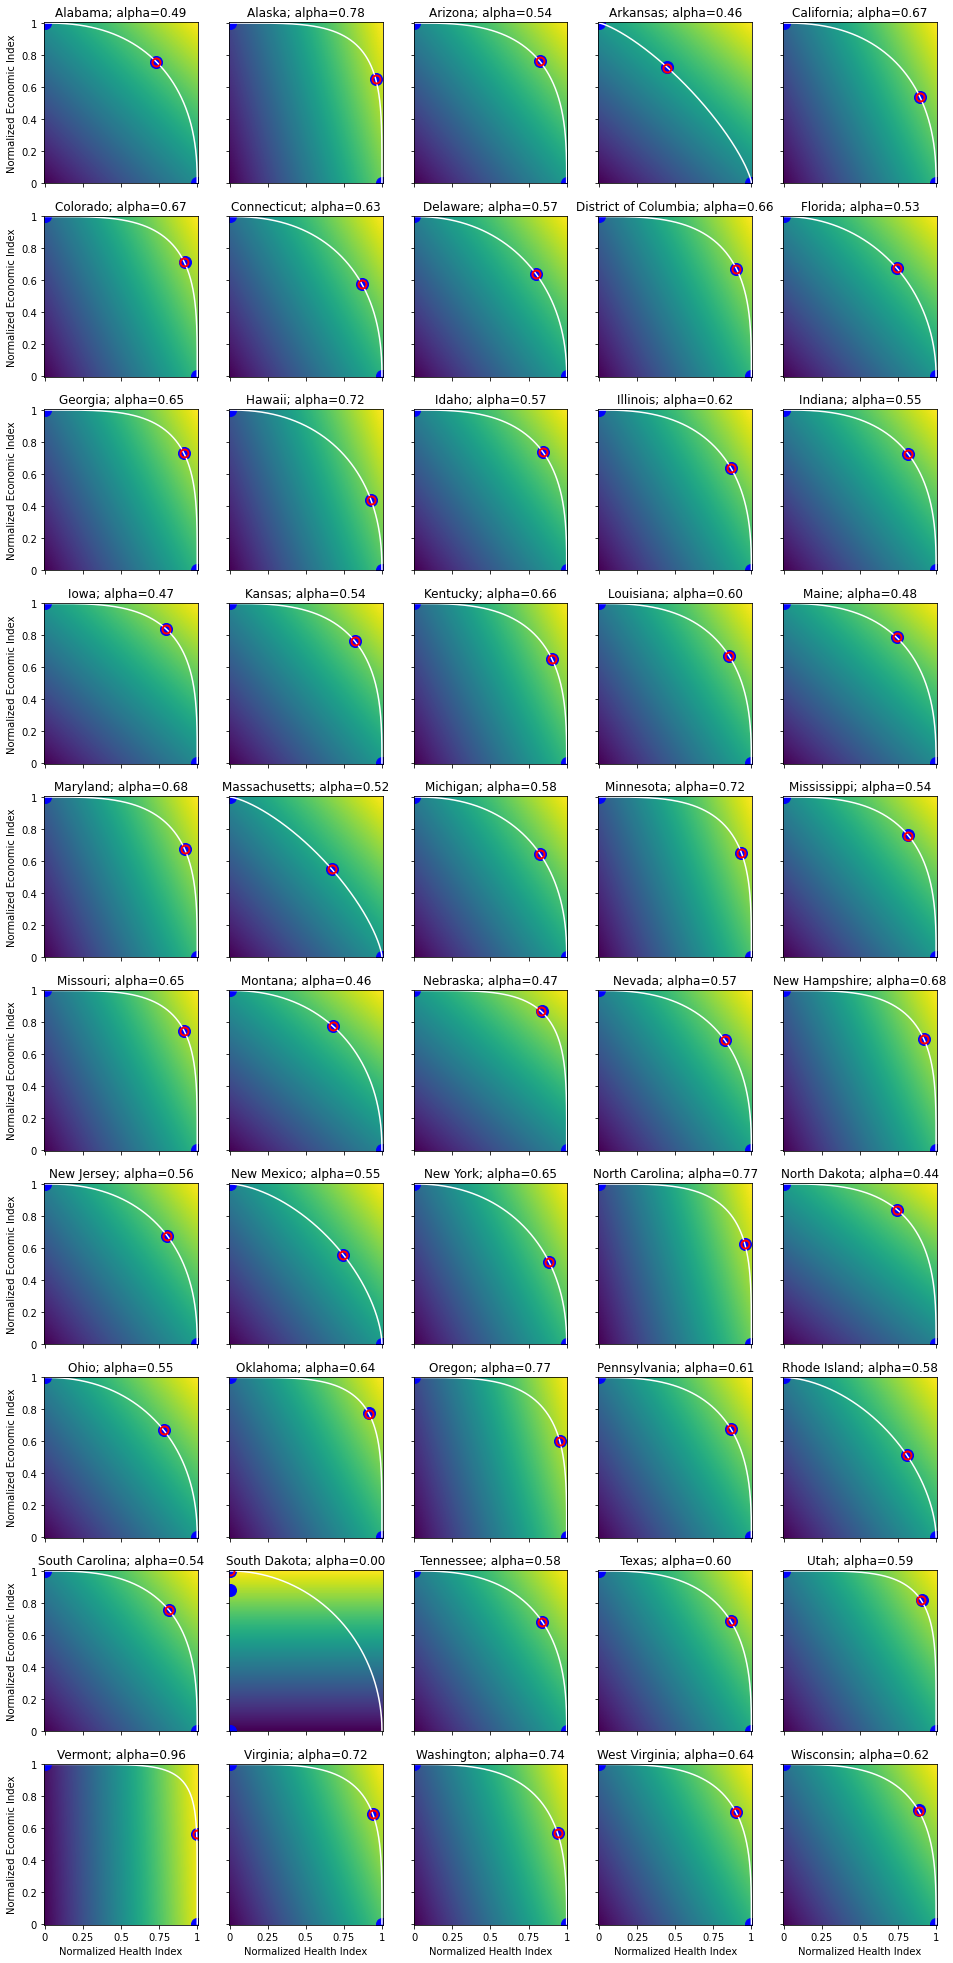

In [30]:
# Now, for all rest of the States!

_, axes = plt.subplots(10, 5, figsize=(16, 35), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    alpha = estimate_alpha_and_plot_rew_examples(state_idx=i, ax=ax)

### Perform the actual calibration fit

At the end of this step, we have finalized the fitted_params_dict and are ready to export the final calibration!

In [31]:
# The fully-closed and fully-open policies give us coordinates for normalizing the indices
fitted_params_dict.update(
    {
        "MAX_MARGINAL_AGENT_ECONOMIC_INDEX": [index_results['open'][i][1] for i in range(51)],
        "MAX_MARGINAL_PLANNER_ECONOMIC_INDEX": index_results['open']['p'][1],
        "MAX_MARGINAL_AGENT_HEALTH_INDEX": [index_results['closed'][i][0] for i in range(51)],
        "MAX_MARGINAL_PLANNER_HEALTH_INDEX": index_results['closed']['p'][0],
        "MIN_MARGINAL_AGENT_ECONOMIC_INDEX": [index_results['closed'][i][1] for i in range(51)],
        "MIN_MARGINAL_PLANNER_ECONOMIC_INDEX": index_results['closed']['p'][1],
        "MIN_MARGINAL_AGENT_HEALTH_INDEX": [index_results['open'][i][0] for i in range(51)],
        "MIN_MARGINAL_PLANNER_HEALTH_INDEX": index_results['open']['p'][0],
    }
)     

# Apply the alpha-estimation procedure to fill in the rest of the fitted params dictionary
fitted_params_dict.update(
    {
        "INFERRED_WEIGHTAGE_ON_AGENT_HEALTH_INDEX": [
            estimate_alpha_and_plot_rew_examples(state_idx=i, do_plot=False) for i in range(51)
        ],
        "INFERRED_WEIGHTAGE_ON_PLANNER_HEALTH_INDEX": estimate_alpha_and_plot_rew_examples(
            state_idx='p', do_plot=False
        ),
    }
)

# We have replaced the placeholders in the original fitted_params_file. All done -- time to re-save!
with open(os.path.join(data_dir, fitted_params_filename), "w") as fp: 
    json.dump(fitted_params_dict, fp)

#  
#  
# Inspection

Use this section to inspect the behavior of the calibrated simulator. As a starting point, we provide some code:
- to re-build an environment instance (now that all the calibration fits have been exported),
- to run that environment using the real-world policies,
- and to compare real-world COVID-19 cases/deaths against what the calibrated simulation predicts given the real-world policies.

In [32]:
# Run the actual policy in the simulation to see what kind of simulated outcomes we get and how they compare.

# (this will now use the fully-calibrated settings)


env_config_dict = {
    # Scenario name - determines which scenario class to use
    "scenario_name": "CovidAndEconomySimulation",

    # The list of components in this simulation
    "components": [
        {"ControlUSStateOpenCloseStatus": {
            # action cooldown period in days.
            # Once a stringency level is set, the state(s) cannot switch to another level
            # for a certain number of days (referred to as the "action_cooldown_period")
            "action_cooldown_period": 28
        }},
        {"FederalGovernmentSubsidyAndQuantitativePolicies": {
            # The number of subsidy levels.
            "num_subsidy_quantitative_policy_level": 15,
            # The number of days over which the total subsidy amount is evenly rolled out.
            "subsidy_quantitative_policy_interval": 15,
            # The maximum annual subsidy that may be allocated per person.
            "max_annual_monetary_unit_per_person": 20000,
        }},
        {"VaccinationCampaign": {
            # The number of vaccines available per million people everyday.
            "daily_vaccines_per_million_people": 3000,
            # The number of days between vaccine deliveries.
            "delivery_interval": 1,
            # The date (YYYY-MM-DD) when vaccination begins
            "vaccine_delivery_start_date": "2021-01-12",
        }},
    ],

    # Date (YYYY-MM-DD) to start the simulation.
    "start_date": "2020-03-22",
    # How long to run the simulation for (in days)
    "episode_length": 730,

    # use_real_world_data (bool): Replay what happened in the real world.
    # Real-world data comprises SIR (susceptible/infected/recovered),
    # unemployment, government policy, and vaccination numbers.
    # This setting also sets use_real_world_policies=True.
    "use_real_world_data": False,
    # use_real_world_policies (bool): Run the environment with real-world policies
    # (stringency levels and subsidies). With this setting and
    # use_real_world_data=False, SIR and economy dynamics are still
    # driven by fitted models.
    "use_real_world_policies": False,
    "csv_validation": False,

    # Let the real-world state government handle the covid-19 restriction, and the federal government still operated by AI
    "state_governments_policies_only": False,
    "path_to_data_and_fitted_params": path_to_data_and_fitted_params,

    # A factor indicating how much more the
    # states prioritize health (roughly speaking, loss of lives due to
    # opening up more) over the economy (roughly speaking, a loss in GDP
    # due to shutting down resulting in more unemployment) compared to the
    # real-world.
    # For example, a value of 1 corresponds to the health weight that
    # maximizes social welfare under the real-world policy, while
    # a value of 2 means that states care twice as much about public health
    # (preventing deaths), while a value of 0.5 means that states care twice
    # as much about the economy (preventing GDP drops).
    "health_priority_scaling_agents": 1,
    # Same as above for the planner
    "health_priority_scaling_planner": 1,

    # Full path to the directory containing
    # the data, fitted parameters and model constants. This defaults to
    # "ai_economist/datasets/covid19_datasets/data_and_fitted_params".
    # For details on obtaining these parameters, please see the notebook
    # "ai-economist-foundation/ai_economist/datasets/covid19_datasets/
    # gather_real_world_data_and_fit_parameters.ipynb".
    

    # Economy-related parameters
    # Fraction of people infected with COVID-19. Infected people don't work.
    "infection_too_sick_to_work_rate": 0.1,
    # Fraction of the population between ages 18-65.
    # This is the subset of the population whose employment/unemployment affects
    # economic productivity.
    "pop_between_age_18_65": 0.6,
    # Percentage of interest paid by the federal
    # government to borrow money from the federal reserve for COVID-19 relief
    # (direct payments). Higher interest rates mean that direct payments
    # have a larger cost on the federal government's economic index.
    "risk_free_interest_rate": 0.03,
    # CRRA eta parameter for modeling the economic reward non-linearity.
    "economic_reward_crra_eta": 2,

    # Number of agents in the simulation (50 US states + Washington DC)
    "n_agents": 51,
    # World size: Not relevant to this simulation, but needs to be set for Foundation
    "world_size": [1, 1],
    # Flag to collate all the agents' observations, rewards and done flags into a single matrix
    "collate_agent_step_and_reset_data": False,
}

calibrated_env = ai_economist.foundation.make_env_instance(**env_config_dict)

Using the real-world data to only initialize the env, and using the fitted models to step through the env.
../../../datasets/covid19_datasets/2024-09-16
Loading real-world data from /home/ubuntu/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/2024-09-16
/home/ubuntu/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/2024-09-16
Key:  policy  - size:  1096
Key:  subsidy  - size:  1096
Key:  quantitative  - size:  1096
Key:  inflation  - size:  1096
Key:  fed_fund_rate  - size:  1100
Key:  us_treasury_yield_long_10_years  - size:  1096
Key:  revenue  - size:  1096
Key:  spending  - size:  1096
Key:  debt  - size:  1096
Key:  deaths  - size:  1096
Key:  vaccinated  - size:  1096
Key:  smoothed_deaths  - size:  1096
Key:  susceptible  - size:  1096
Key:  infected  - size:  1096
Key:  recovered  - size:  1096
Key:  beta  - size:  1096
Key:  unemployment  - size:  1096
Key:  unemployed  - size:  1096
Loading fit 

In [33]:
# Run sim, setting agent actions based on the real-world policy
calibrated_env.reset();
for _ in range(calibrated_env.episode_length):
    t_str = calibrated_env.current_date.strftime(DATE_FORMAT)
    actions = {
        str(idx): policy_df[state][t_str]
        for idx, state in calibrated_env.us_state_idx_to_state_name.items()
    }
    calibrated_env.step(actions);

Day  1
Postsubsidy Productivity  0.0
Day  2
Postsubsidy Productivity  47321084000.0
Day  3
Postsubsidy Productivity  99406330000.0
Day  4
Postsubsidy Productivity  151130440000.0
Day  5
Postsubsidy Productivity  202633220000.0
Day  6
Postsubsidy Productivity  253926210000.0
Day  7
Postsubsidy Productivity  304968600000.0
Day  8
Postsubsidy Productivity  355787830000.0
Day  9
Postsubsidy Productivity  406442200000.0
Day  10
Postsubsidy Productivity  456877500000.0
Day  11
Postsubsidy Productivity  507090960000.0
Day  12
Postsubsidy Productivity  557144100000.0
Day  13
Postsubsidy Productivity  607000300000.0
Day  14
Postsubsidy Productivity  656631000000.0
Day  15
Postsubsidy Productivity  706125230000.0
Day  16
Postsubsidy Productivity  755489200000.0
Day  17
Postsubsidy Productivity  804689150000.0
Day  18
Postsubsidy Productivity  853758500000.0
Day  19
Postsubsidy Productivity  902704660000.0
Day  20
Postsubsidy Productivity  951475040000.0
Day  21
Postsubsidy Productivity  10001316

Day  43
Postsubsidy Productivity  2052110000000.0
Day  44
Postsubsidy Productivity  2099509000000.0
Day  45
Postsubsidy Productivity  2146963800000.0
Day  46
Postsubsidy Productivity  2194408900000.0
Day  47
Postsubsidy Productivity  2241860700000.0
Day  48
Postsubsidy Productivity  2289305400000.0
Day  49
Postsubsidy Productivity  2336780500000.0
Day  50
Postsubsidy Productivity  2384296100000.0
Day  51
Postsubsidy Productivity  2431819200000.0
Day  52
Postsubsidy Productivity  2479358000000.0
Day  53
Postsubsidy Productivity  2526909300000.0
Day  54
Postsubsidy Productivity  2574474500000.0
Day  55
Postsubsidy Productivity  2622053000000.0
Day  56
Postsubsidy Productivity  2669657700000.0
Day  57
Postsubsidy Productivity  2717326200000.0
Day  58
Postsubsidy Productivity  2765011800000.0
Day  59
Postsubsidy Productivity  2812714200000.0
Day  60
Postsubsidy Productivity  2860434000000.0
Day  61
Postsubsidy Productivity  2908166800000.0
Day  62
Postsubsidy Productivity  2956000200000.0


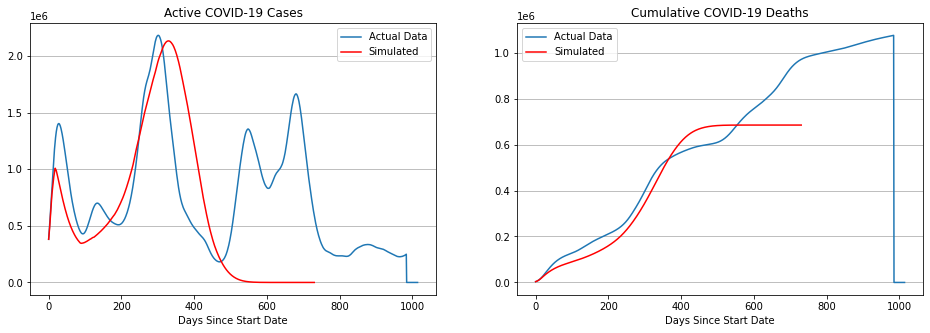

In [34]:
# Visualize active cases and deaths, for the real-world and for the simulation w/ real-world policies
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))


infected_df = dataframes["infected"]
deaths_df = dataframes["smoothed_deaths"]

ax0.plot(infected_df[
    fitted_params_dict['settings']['env']['start_date']:fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']
].sum(1).values, label='Actual Data');
ax0.plot(calibrated_env.world.global_state["Infected"][:, :].sum(1), 'r', label='Simulated');
ax0.set_title('Active COVID-19 Cases');
ax0.set_xlabel('Days Since Start Date');
ax0.grid(b=True, axis='y');
ax0.legend();

ax1.plot(deaths_df[
    fitted_params_dict['settings']['env']['start_date']:fitted_params_dict['settings']['LAST_DATE_IN_VAL_SET']
].sum(1).values, label='Actual Data');
ax1.plot(calibrated_env.world.global_state['Deaths'][:, :].sum(1), 'r', label='Simulated');
ax1.set_title('Cumulative COVID-19 Deaths');
ax1.set_xlabel('Days Since Start Date');
ax1.grid(b=True, axis='y');
ax1.legend();